## Processing Data to get 2D images for training purposes

#### Installing libraries for reading Off files and then turning them into png

In [ ]:
!python -m pip install -U kaleido plotly

In [14]:
import os
import numpy as np
from time import time
from collections import Counter
from pprint import pprint
import plotly.graph_objects as go
import numpy as np

Navigating and loading data

In [15]:
path = '/home/dele/Documents/Machine_learning/TF/ModelNet10/'
labels = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
files = [os.path.join(path,l,'train',ll) for l in labels
         for ll in os.listdir(os.path.join(path, l, 'train'))
         if ll[-4:] == '.off']

print(labels)
pprint(Counter([f.split('ModelNet10/')[1].split('/')[0] for f in files]))

['dresser', 'bathtub', 'desk', 'chair', 'night_stand', 'monitor', 'sofa', 'table', 'toilet', 'bed']
Counter({'chair': 889,
         'sofa': 680,
         'bed': 515,
         'monitor': 465,
         'table': 392,
         'toilet': 344,
         'dresser': 200,
         'desk': 200,
         'night_stand': 200,
         'bathtub': 106})


Functions necessary for generating png files given the ModelNet10 dataset

In [14]:
def readOff(filename):
    f = open(filename)
    f.readline()
    nvertices, nfaces, nedges = map(int, f.readline().split())
    #print(f"Vertices: {nvertices}, Faces: {nfaces}, Edges: {nedges}")
    vertices = []
    for _ in range(nvertices):
        vertices.append(list(map(float, f.readline().strip().split())))

    vertices = np.array(vertices)

    triangles = []
    for _ in range(nfaces):
        face = list(map(int, f.readline().strip().split()))
        ntriangles, verts = face[0] - 3 + 1, face[1:]
        for n in range(ntriangles):
            triangles.append([verts[0], verts[1 + n], verts[2 + n]])

    triangles = np.array(triangles)

    return vertices, triangles

In [33]:
def save(filename):
    vertices, faces = readOff(filename)

    x, y, z = vertices.T
    I, J, K = faces.T

    mesh = go.Mesh3d(
                x=-x,
                y=y,
                z=z,
                #vertexcolor=vertices[:, 3:], #the color codes must be triplets of floats  in [0,1]!!
                i=I,
                j=J,
                k=K,
                name='',
                showscale=False,
                #opacity = 0.75,
                color = 'grey')# Download data set from plotly repo


    fig = go.Figure(data=mesh)
    fig.update_layout(
        scene = dict(
            xaxis = dict(visible=False),
            yaxis = dict(visible=False),
            zaxis =dict(visible=False)
            ),
            #width=300,  # Set the desired width
            #height=100  # Set the desired height
        )
    fig.write_image("testImage.png")
    #fig.show()

Testing out saving a testImage to see results

In [34]:
save('ModelNet10/bathtub/test/bathtub_0138.off') 

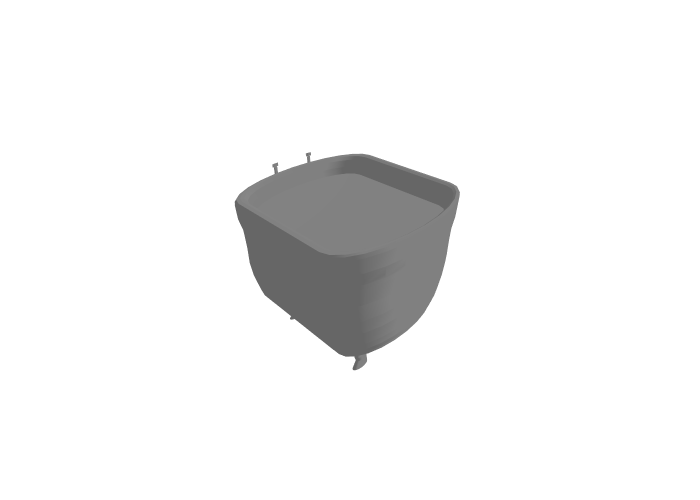

### Modifying function so it turns every .off file to a png in other folder

In [22]:
def convert_off_to_png(input_folder, output_folder):
    # Iterate through the categories in ModelNet10
    categories = {
        'chair': 889,
        'sofa': 680,
        'bed': 515,
        'monitor': 465,
        'table': 392,
        'toilet': 344,
        'dresser': 200,
        'desk': 200,
        'night_stand': 200,
        'bathtub': 106
    }

    for category, num_samples in categories.items():
        for dataset_type in ['train', 'test']:
            input_category_folder = os.path.join(input_folder, category, dataset_type)
            output_category_folder = os.path.join(output_folder, category, dataset_type, 'Images')

            # Create the output directory if it doesn't exist
            os.makedirs(output_category_folder, exist_ok=True)

            # Iterate through all files in the category and convert .off to .png
            for filename in os.listdir(input_category_folder):
                if filename.endswith(".off"):
                    input_filename = os.path.join(input_category_folder, filename)
                    output_filename = os.path.join(output_category_folder, f"{os.path.splitext(filename)[0]}.png")

                    try:
                        vertices, faces = readOff(input_filename)
                        x, y, z = vertices.T
                        I, J, K = faces.T

                        mesh = go.Mesh3d(
                            x=-x,
                            y=y,
                            z=z,
                            i=I,
                            j=J,
                            k=K,
                            name='',
                            showscale=False,
                            color='grey'
                        )

                        fig = go.Figure(data=mesh)
                        fig.update_layout(
                            scene=dict(
                                xaxis=dict(visible=False),
                                yaxis=dict(visible=False),
                                zaxis=dict(visible=False)
                            )
                        )
                        fig.write_image(output_filename)
                        print(f"Converted {input_filename} to {output_filename}")
                    except Exception as e:
                        print(f"Error converting {input_filename}: {str(e)}")


In [ ]:
input_folder = path
output_folder = "/home/dele/Documents/Machine_learning/TF/Images/"

convert_off_to_png(input_folder, output_folder)

### GAN will be recieving 3d input as voxels in a numpy array the same will apply to 2d 

png to numpy array

In [35]:
from PIL import Image

In [36]:
def process_png_folder(input_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.png'):
            file_path = os.path.join(input_folder, file_name)
            destination_path = os.path.join(dest_folder, f'{file_name[:-4]}.npy')

            img = Image.open(file_path)
            img_array = np.array(img)
            np.save(destination_path, img_array)

# Example usage
input_folder = '/home/dele/Documents/Machine_learning/TF/Images/chair/train/'
destination_folder = '/home/dele/Documents/Machine_learning/TF/Train2D_Data'
process_png_folder(input_folder, destination_folder)


from .off files to voxel numpy array

In [9]:
import os
import random
import math
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
from time import time
import binvox_rw

In [ ]:
# generate file
file = random.choice(files)
def check_fix_file(file):
    with open(file) as f:
        l1 = f.readline()
        l2 = f.readlines()

    if l1 != 'OFF\n' and l1[:3] == 'OFF':
        out = 'OFF\n'
        out += l1.split('OFF')[1]
        out += ''.join(l2)
        with open(file, 'w') as f:
            f.write(out)

def voxels_from_file(file, voxsize):
    cmd = f'/home/dele/Documents/Machine_learning/TF/binvox/binvox -d {voxsize} -cb -e {file}'
    check_fix_file(file)
    out_file = file.split('.')[0] + '.binvox'
            
    if os.path.exists(out_file):
        os.remove(out_file)

    t = os.system(cmd)
    
    if t == 0:
        with open(out_file, 'rb') as f:
            d = binvox_rw.read_as_3d_array(f).data
        
        os.remove(out_file)
        return 1, d
    else:
        return 0, None

voxels = voxels_from_file(file, 32)
print('\nPlotting:', file)


In [22]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def multithreading(func, args, workers):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args)
    return list(res)

get_label = lambda x: x.split('ModelNet')[1][3:].split('/')[0]

def get_voxels(files, voxsize):
    data = np.ndarray((0, *[voxsize]*3), dtype=bool)
    labels = []
    errors = []
    
    for i, file in enumerate(files):
        res = voxels_from_file(file, voxsize)
        if res[0] == 1:
            labels.append(get_label(file))
            data = np.vstack([data, res[1].reshape((1, *res[1].shape))])
        else:
            errors.append(file)

    return labels, data, errors

get_voxels_parallel = lambda x: get_voxels(*x)

def convert_all(path, voxsize):
    out_file = os.path.join(path, 'voxels.npy')
    labels = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    train_files = [os.path.join(path,l,'train',ll) for l in labels
                   for ll in os.listdir(os.path.join(path, l, 'train'))
                   if ll[-4:] == '.off']
    test_files = [os.path.join(path,l,'test',ll) for l in labels
                   for ll in os.listdir(os.path.join(path, l, 'test'))
                   if ll[-4:] == '.off']

    print(f'train: {len(train_files)}, test: {len(test_files)}')
    
    n_cpu = multiprocessing.cpu_count()
    output = {}
    
    for data_files, data_name in zip([train_files, test_files], ['train', 'test']):
        t0 = time()
        print(f'Launching {n_cpu} threads for {data_name} set...', end='')
        thread_size = math.ceil(len(data_files) / n_cpu)
        args = [(data_files[i*thread_size:(i+1)*thread_size], voxsize) for i in range(n_cpu)]
        res = multithreading(get_voxels_parallel, args, n_cpu)
        labels = []
        data = np.ndarray((0, *[voxsize]*3), dtype=bool)
        errors = []

        for l, d, e in res:
            labels += l
            data = np.vstack([data, d])
            errors += e
            
        output[data_name] = {'labels': labels, 'data': data, 'errors': errors}
        
        print('(%.2fs)' % (time() - t0))
    
    np.save(out_file, output)    
    print('\nSaved on: %s (%.2fM)' % (out_file, os.path.getsize(out_file) / 1024**2))

In [ ]:
convert_all('/home/dele/Documents/Machine_learning/TF/ModelNet10/', voxsize=32)

### Once all data has been transformed into png images we can start training GAN